In [3]:
import itertools
from os import listdir

import cv2
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau, TensorBoard)
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  img_to_array)

In [4]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def preprocess_image(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    return image

In [5]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
cm_plot_labels = ['Early_blight','Healthy','Late_blight']

In [7]:
#setting the early stopping and learning rate reduction callbacks to use for training
early_stopping_monitor = EarlyStopping(monitor = "val_loss",patience = 5,min_delta = 0.0001,restore_best_weights = True,verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_loss",paitence = 4,factor = 0.5,patience = 4,min_lr = 1e-7,verbose = 1)

In [8]:
#basic variables definition
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
depth=3
IMG_SIZE = 224
NUM_CLASSES = 3

#Colored DataSet

In [42]:
#paths of train val and test directories of the first dataset
train_dir = "/content/drive/MyDrive/Private Data Split_train_test_val/train"
val_dir = "/content/drive/MyDrive/Private Data Split_train_test_val/val"
test_dir  = "/content/drive/MyDrive/Private Data Split_train_test_val/test"

In [43]:
#loading the dataset
train_data = image_dataset_from_directory(train_dir,label_mode="categorical",image_size = (IMG_SIZE,IMG_SIZE),batch_size = BS,seed = 42,shuffle = True)
val_data = image_dataset_from_directory(val_dir,label_mode="categorical",image_size = (IMG_SIZE,IMG_SIZE),batch_size = BS,seed = 42,shuffle = False)
test_data = image_dataset_from_directory(test_dir,label_mode="categorical",image_size = (IMG_SIZE,IMG_SIZE),batch_size = BS,seed = 42,shuffle = False)

Found 2060 files belonging to 3 classes.
Found 589 files belonging to 3 classes.
Found 295 files belonging to 3 classes.


In [44]:
print(train_data)
print(test_data)
print(val_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [45]:
class_names = train_data.class_names
print(len(class_names))
print(class_names)

3
['Early_blight', 'Healthy', 'Late_blight']


In [46]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

In [16]:
#model architecture definition
model = EfficientNetB5(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, depth), weights="imagenet")

# Freeze the pretrained weights
model.trainable = False
#model.trainable = True

# Rebuild top
x = GlobalAveragePooling2D(name="avg_pool")(model.output)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

115263384/115263384 [==============================] - 6s 0us/step


In [17]:
# Compile
model = tf.keras.Model(model.input, outputs, name="EfficientNet")

In [18]:
optimizer = tf.keras.optimizers.Adam(beta_1 = 0.9, beta_2 = 0.999, decay = 0.0,learning_rate=0.001)

In [19]:
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
) 
#return model

In [20]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]'

In [22]:
#model training
history = model.fit(train_data,epochs=20,steps_per_epoch=len(train_data),validation_data = val_data,validation_steps = int(0.25*len(val_data)),verbose=1,callbacks=[learning_rate_reduction,early_stopping_monitor])

Epoch 1/20
65/65 [==============================] - 739s 10s/step - loss: 0.2361 - accuracy: 0.9034 - val_loss: 0.5054 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - 17s 246ms/step - loss: 0.0848 - accuracy: 0.9699 - val_loss: 0.3815 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - 17s 243ms/step - loss: 0.0661 - accuracy: 0.9767 - val_loss: 0.1749 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - 16s 236ms/step - loss: 0.0461 - accuracy: 0.9825 - val_loss: 0.1262 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 5/20
65/65 [==============================] - 16s 238ms/step - loss: 0.0557 - accuracy: 0.9806 - val_loss: 0.0793 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 6/20
65/65 [==============================] - 19s 277ms/step - loss: 0.0455 - accuracy: 0.9840 - val_loss: 0.0830 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 7/20
65/65 [==============================] - 17s 246ms/ste

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


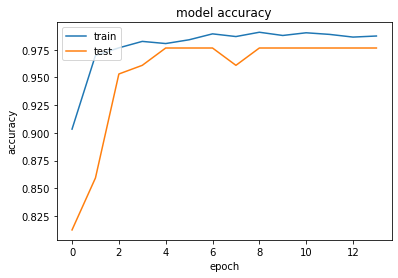

In [23]:
#plotting the accuracy history during training and testing
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

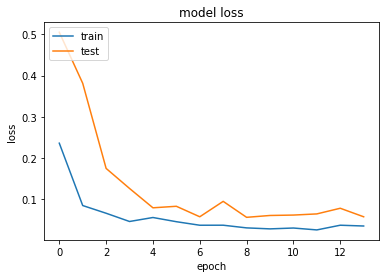

In [24]:
#plotting the loss history during training and testing
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
#model saving
model.save('trained_model_colored.h5')

In [27]:
#model prediction on val data
predictions = model.predict(
      x=test_data
    , batch_size=32
    , verbose=1
)  

10/10 [==============================] - 104s 10s/step


In [28]:
rounded_predictions=np.argmax(predictions,axis=-1)

In [32]:
test_dataset = [(example.numpy(), label.numpy()) for example, label in test_data]


In [41]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

In [118]:
array_test1=get_labels_from_tfdataset(test_data)

In [119]:

test_labels =np.array([])

In [120]:
for i in array_test1:
  result=np.where(i==1)[0][0]
  test_labels=np.append(test_labels,result)
test_labels.astype(int)
print(test_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2.]


In [121]:
cm = confusion_matrix(y_true=test_labels,y_pred=rounded_predictions)

Confusion matrix, without normalization
[[ 99   0   1]
 [  0  92   3]
 [  0   0 100]]


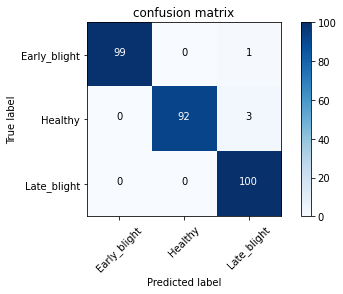

In [122]:
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title="confusion matrix")

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
data_aug = tf.keras.Sequential([
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.Rescaling(1/255.)
],name = "data_augmentation_layer")

#Segmented DataSet

In [123]:
train_dir = "/content/drive/MyDrive/datasetCBL/Segmented_train_test_val/train"
val_dir = "/content/drive/MyDrive/datasetCBL/Segmented_train_test_val/val"
test_dir  = "/content/drive/MyDrive/datasetCBL/Segmented_train_test_val/test"

In [124]:
train_data2 = image_dataset_from_directory(train_dir,label_mode="categorical",image_size = (IMG_SIZE,IMG_SIZE),batch_size = BS,seed = 42,shuffle = True)


val_data2 = image_dataset_from_directory(val_dir,label_mode="categorical",image_size = (IMG_SIZE,IMG_SIZE),batch_size = BS,seed = 42,shuffle = False)


test_data2 = image_dataset_from_directory(test_dir,label_mode="categorical",image_size = (IMG_SIZE,IMG_SIZE),batch_size = BS,seed = 42,shuffle = False)

Found 1506 files belonging to 3 classes.
Found 430 files belonging to 3 classes.
Found 216 files belonging to 3 classes.


In [127]:
print(train_data2)
print(test_data2)
print(val_data2)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [128]:
class_names2 = train_data2.class_names
print(len(class_names2))
print(class_names2)

3
['Early_blight', 'Healthy', 'Late_blight']


In [129]:
train_data2 = train_data2.prefetch(tf.data.AUTOTUNE)
test_data2 = test_data2.prefetch(tf.data.AUTOTUNE)
val_data2 = val_data2.prefetch(tf.data.AUTOTUNE)

In [130]:
model2 = EfficientNetB5(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, depth), weights="imagenet")

# Freeze the pretrained weights
model2.trainable = False
#model2.trainable = True

# Rebuild top
x = GlobalAveragePooling2D(name="avg_pool")(model2.output)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs2 = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

In [131]:
# Compile
model2 = tf.keras.Model(model2.input, outputs2, name="EfficientNet")

In [132]:
optimizer = tf.keras.optimizers.Adam(beta_1 = 0.9, beta_2 = 0.999, decay = 0.0,learning_rate=0.001)

In [133]:
model2.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
) 
#return model

In [134]:
model2.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                       

In [135]:
history2 = model2.fit(train_data2,epochs=20,steps_per_epoch=len(train_data2),validation_data = val_data2,validation_steps = int(0.25*len(val_data2)),verbose=1,callbacks=[learning_rate_reduction,early_stopping_monitor])

Epoch 1/20
48/48 [==============================] - 717s 12s/step - loss: 0.5712 - accuracy: 0.7663 - val_loss: 0.3900 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 2/20
48/48 [==============================] - 12s 229ms/step - loss: 0.2315 - accuracy: 0.9163 - val_loss: 0.4243 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 3/20
48/48 [==============================] - 12s 235ms/step - loss: 0.1906 - accuracy: 0.9276 - val_loss: 0.2761 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/20
48/48 [==============================] - 12s 236ms/step - loss: 0.1417 - accuracy: 0.9495 - val_loss: 0.2174 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/20
48/48 [==============================] - 12s 239ms/step - loss: 0.1449 - accuracy: 0.9429 - val_loss: 0.1534 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 6/20
48/48 [==============================] - 12s 238ms/step - loss: 0.1359 - accuracy: 0.9482 - val_loss: 0.0907 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 7/20
48/48 [==============================] - 12s 236ms/ste

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


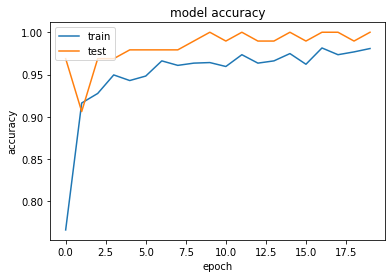

In [136]:
print(history2.history.keys())
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

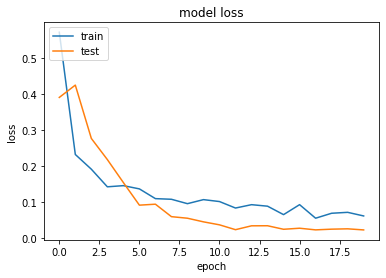

In [137]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [138]:
model2.save('trained_model_segmented.h5')

In [139]:
predictions2 = model2.predict(
      x=test_data2
    , batch_size=32
    , verbose=1
)  

7/7 [==============================] - 104s 14s/step


In [140]:
rounded_predictions2=np.argmax(predictions2,axis=-1)

In [141]:
array_test2=get_labels_from_tfdataset(test_data2)

In [142]:
test_labels2 =np.array([])

In [143]:
for i in array_test2:
  result=np.where(i==1)[0][0]
  test_labels2=np.append(test_labels2,result)
test_labels2.astype(int)
print(test_labels2)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [144]:
cm2 = confusion_matrix(y_true=test_labels2,y_pred=rounded_predictions2)

Confusion matrix, without normalization
[[99  0  1]
 [ 0 16  0]
 [ 0  2 98]]


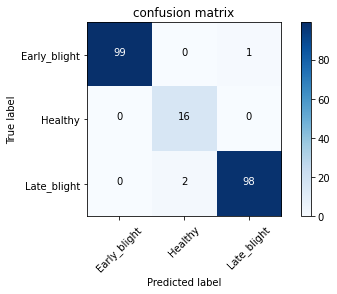

In [145]:
plot_confusion_matrix(cm=cm2,classes=cm_plot_labels,title="confusion matrix")

#Segmented HSV DataSet

In [146]:
train_dir = "/content/drive/MyDrive/datasetCBL/Segmented_HSV_train_test_val/train"
val_dir = "/content/drive/MyDrive/datasetCBL/Segmented_HSV_train_test_val/val"
test_dir  = "/content/drive/MyDrive/datasetCBL/Segmented_HSV_train_test_val/test"

In [147]:
train_data3 = image_dataset_from_directory(train_dir,label_mode="categorical",image_size = (IMG_SIZE,IMG_SIZE),batch_size = BS,seed = 42,shuffle = True)


val_data3 = image_dataset_from_directory(val_dir,label_mode="categorical",image_size = (IMG_SIZE,IMG_SIZE),batch_size = BS,seed = 42,shuffle = False)


test_data3 = image_dataset_from_directory(test_dir,label_mode="categorical",image_size = (IMG_SIZE,IMG_SIZE),batch_size = BS,seed = 42,shuffle = False)

Found 1506 files belonging to 3 classes.
Found 430 files belonging to 3 classes.
Found 216 files belonging to 3 classes.


In [148]:
print(train_data3)
print(test_data3)
print(val_data3)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [149]:
class_names3 = train_data3.class_names
print(len(class_names3))
print(class_names3)

3
['Early_blight', 'Healthy', 'Late_blight']


In [150]:
train_data3 = train_data3.prefetch(tf.data.AUTOTUNE)
test_data3 = test_data3.prefetch(tf.data.AUTOTUNE)
val_data3 = val_data3.prefetch(tf.data.AUTOTUNE)

In [151]:
model3 = EfficientNetB5(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, depth), weights="imagenet")

# Freeze the pretrained weights
model3.trainable = False
#model2.trainable = True

# Rebuild top
x = GlobalAveragePooling2D(name="avg_pool")(model3.output)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs3 = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

In [152]:
# Compile
model3 = tf.keras.Model(model3.input, outputs3, name="EfficientNet3")

In [153]:
optimizer = tf.keras.optimizers.Adam(beta_1 = 0.9, beta_2 = 0.999, decay = 0.0,learning_rate=0.001)

In [154]:
model3.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
) 
#return model

In [155]:
model3.summary()

Model: "EfficientNet3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                      

In [156]:
history3 = model3.fit(train_data3,epochs=20,steps_per_epoch=len(train_data3),validation_data = val_data3,validation_steps = int(0.25*len(val_data3)),verbose=1,callbacks=[learning_rate_reduction,early_stopping_monitor])

Epoch 1/20
48/48 [==============================] - 460s 8s/step - loss: 0.8117 - accuracy: 0.6766 - val_loss: 0.3012 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 2/20
48/48 [==============================] - 12s 246ms/step - loss: 0.3730 - accuracy: 0.8493 - val_loss: 0.2237 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 3/20
48/48 [==============================] - 12s 247ms/step - loss: 0.3147 - accuracy: 0.8851 - val_loss: 0.2174 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 4/20
48/48 [==============================] - 12s 249ms/step - loss: 0.2547 - accuracy: 0.8971 - val_loss: 0.2007 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 5/20
48/48 [==============================] - 12s 242ms/step - loss: 0.2474 - accuracy: 0.9064 - val_loss: 0.1788 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 6/20
48/48 [==============================] - 12s 245ms/step - loss: 0.2475 - accuracy: 0.9077 - val_loss: 0.1685 - val_accuracy: 0.9271 - lr: 0.0010
Epoch 7/20
48/48 [==============================] - 12s 246ms/step

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


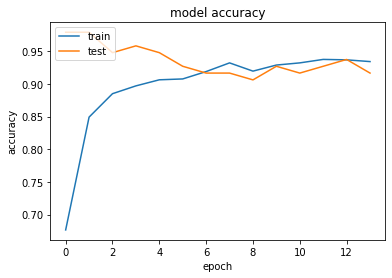

In [157]:
print(history3.history.keys())
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

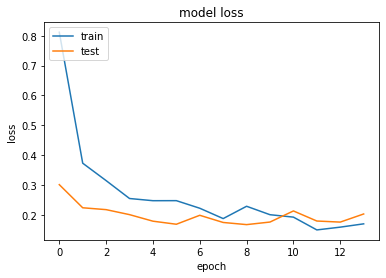

In [158]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [159]:
model3.save('trained_model_segmented_hsv.h5')

In [160]:
predictions3 = model3.predict(
      x=test_data3
    , batch_size=32
    , verbose=1
)  

7/7 [==============================] - 93s 13s/step


In [161]:
rounded_predictions3=np.argmax(predictions3,axis=-1)

In [162]:
array_test3=get_labels_from_tfdataset(test_data3)

In [163]:
test_labels3 =np.array([])

In [164]:
for i in array_test3:
  result=np.where(i==1)[0][0]
  test_labels3=np.append(test_labels3,result)
test_labels3.astype(int)
print(test_labels3)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [165]:
cm3 = confusion_matrix(y_true=test_labels3,y_pred=rounded_predictions3)

Confusion matrix, without normalization
[[97  1  2]
 [ 0 12  4]
 [ 6  1 93]]


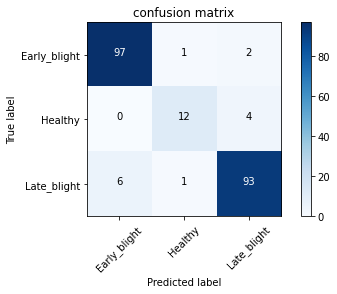

In [166]:
plot_confusion_matrix(cm=cm3,classes=cm_plot_labels,title="confusion matrix")